# Energy Consumption Analysis

#### Libraries

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#### Date Prepa

In [5]:
df = pd.read_csv('Steel_industry_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
df.index = df.index.map(adjust_date)

df.columns
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


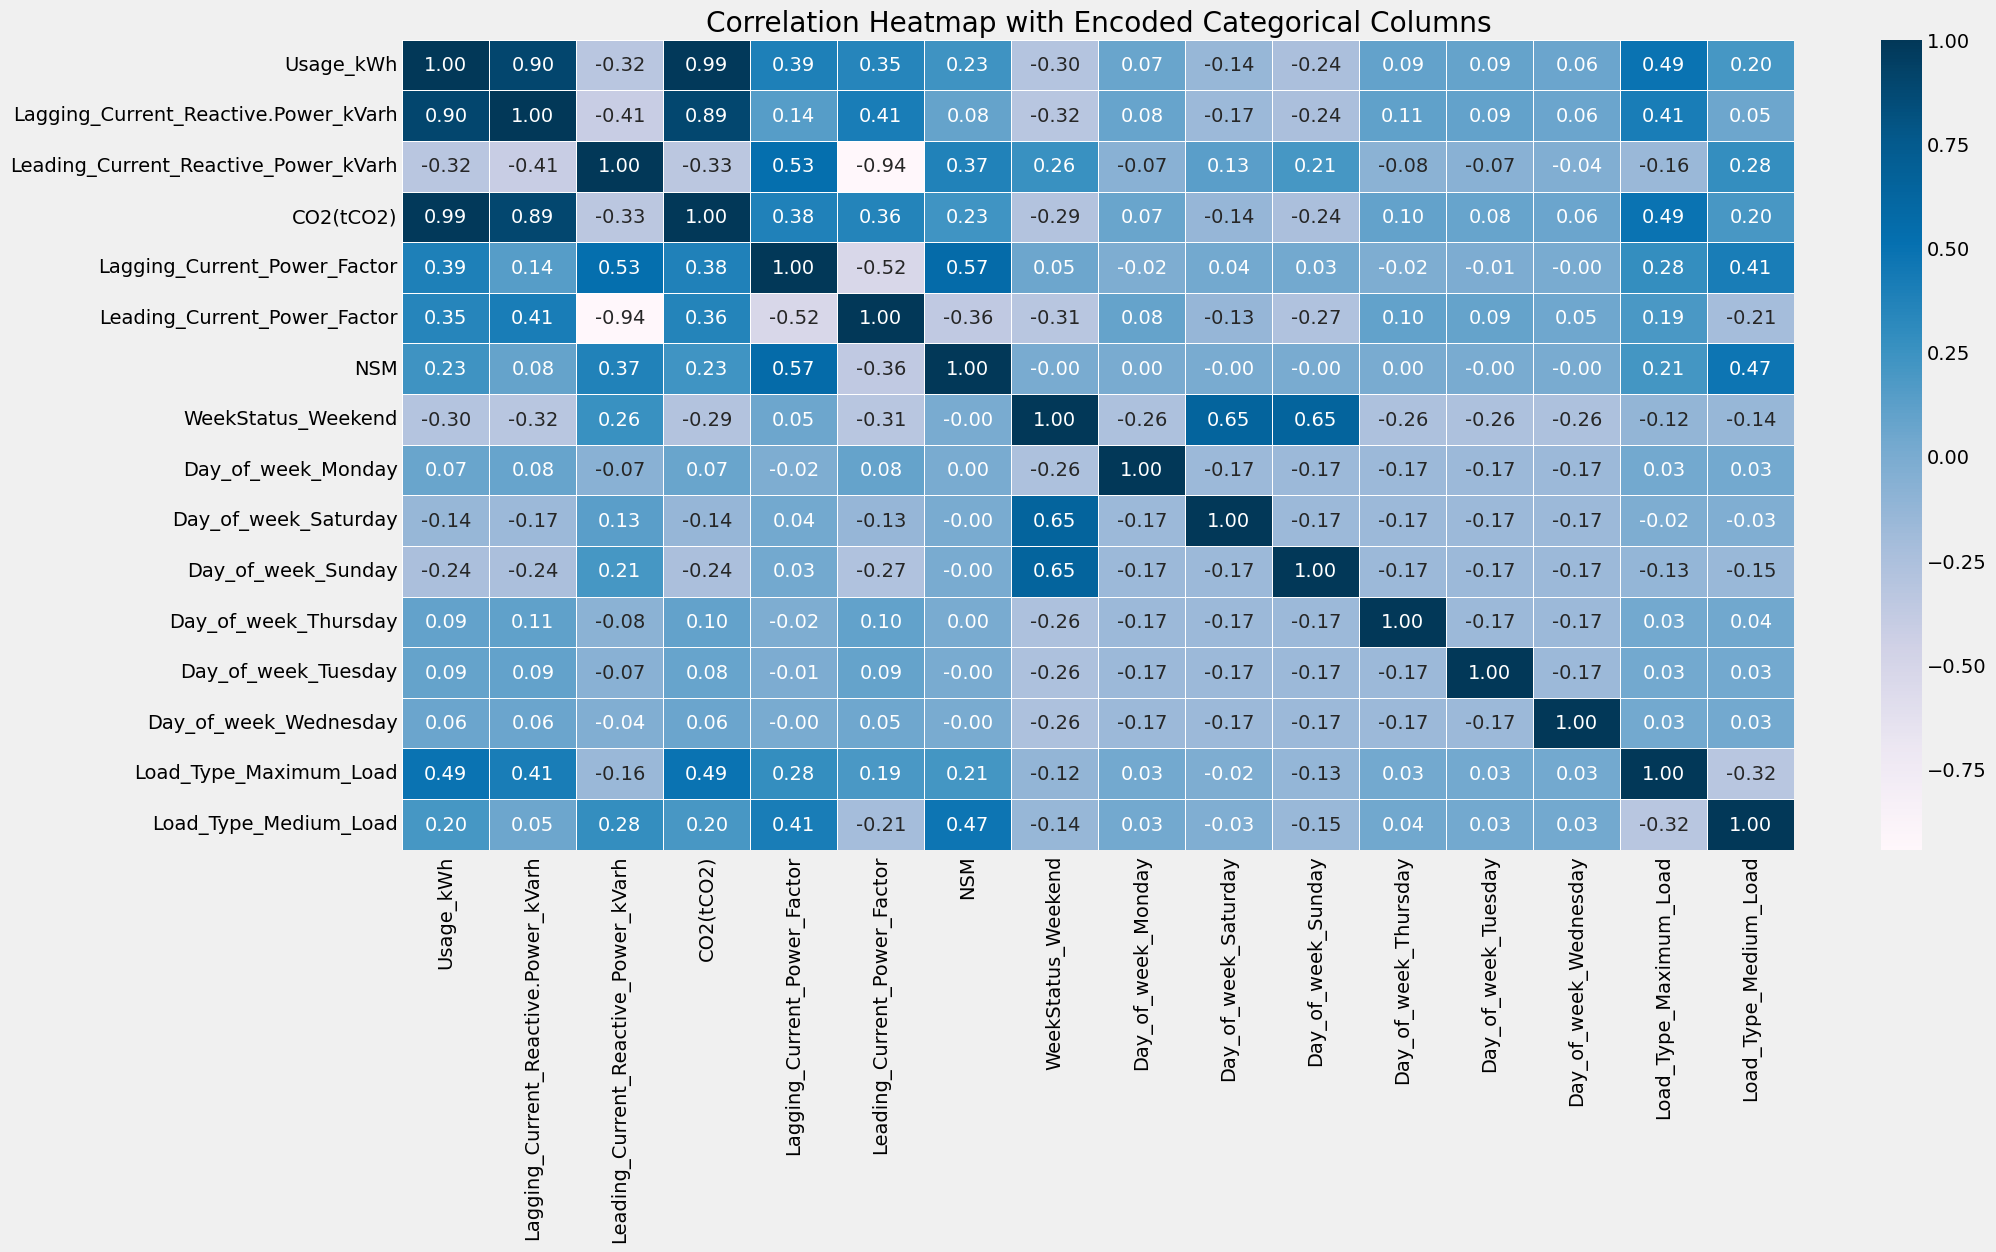

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Example: df = pd.read_csv('your_data.csv')

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], drop_first=True)

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='PuBu', fmt='.2f', linewidths=0.5)

# Add title and labels
plt.xticks(rotation=90)
plt.title('Correlation Heatmap with Encoded Categorical Columns')
plt.savefig('dataset heat map')
plt.show()

# Daily Energy Usage Insights

## Average Daily Energy Usage

In [8]:
df_weekly_avg = df.groupby('Day_of_week')['Usage_kWh'].mean().reset_index()
# Define correct order of weekdays
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Sort the dataframe by day_order
df_weekly_avg['Day_of_week'] = pd.Categorical(df_weekly_avg['Day_of_week'], categories=day_order, ordered=True)
df_weekly_avg = df_weekly_avg.sort_values('Day_of_week')



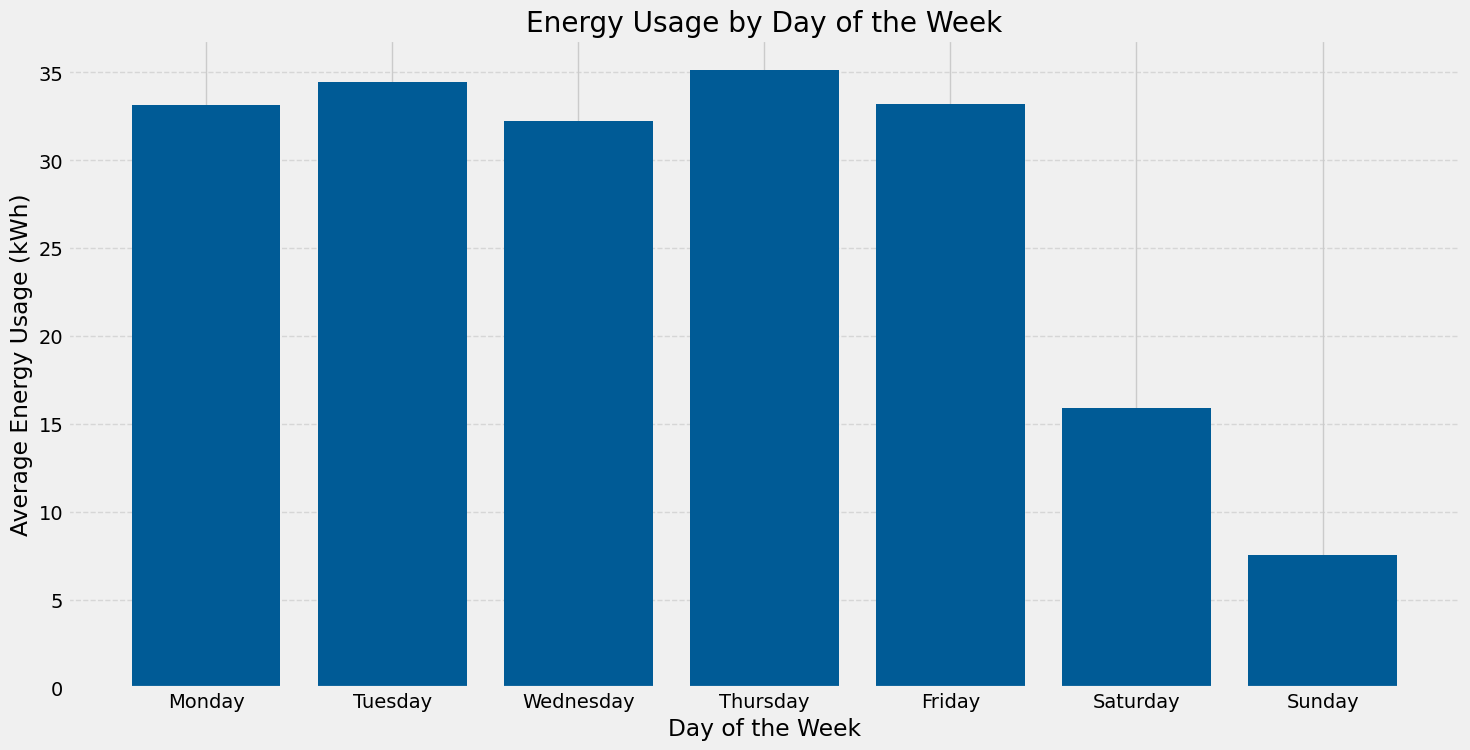

In [19]:
plt.figure(figsize=(16, 8))
plt.bar(df_weekly_avg['Day_of_week'], df_weekly_avg['Usage_kWh'], color="#005b96")

# Formatting the plot
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Usage (kWh)')
plt.title('Energy Usage by Day of the Week')
plt.xticks(rotation=0)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('avg_daily_usage.png')
# Show the plot
plt.show()


## Total Daily Energy Usage

In [26]:
df_weekly_total = df.groupby('Day_of_week')['Usage_kWh'].sum().reset_index()
# Define correct order of weekdays
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Sort the dataframe by day_order
df_weekly_total['Day_of_week'] = pd.Categorical(df_weekly_total['Day_of_week'], categories=day_order, ordered=True)
df_weekly_total = df_weekly_total.sort_values('Day_of_week')

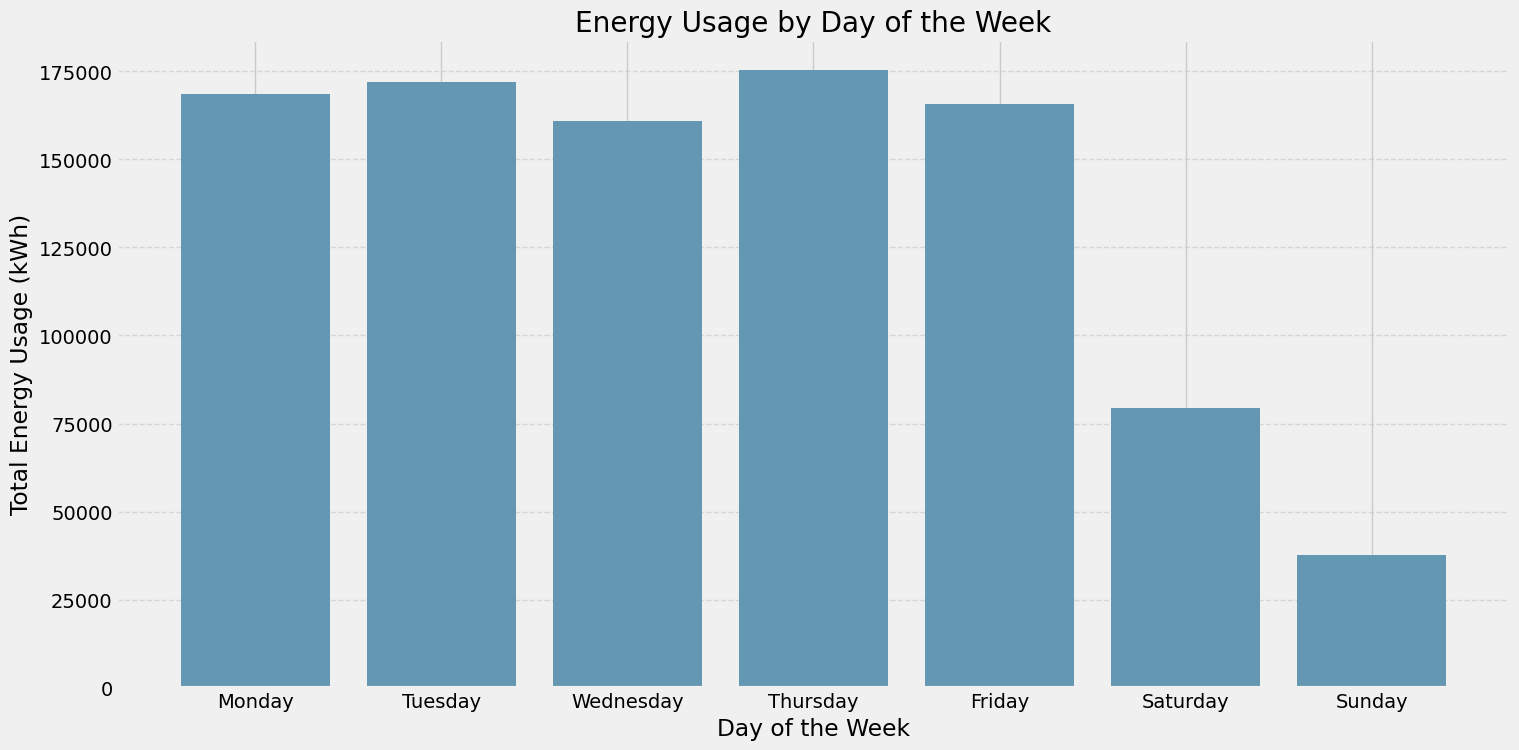

In [30]:
plt.figure(figsize=(16, 8))
plt.bar(df_weekly_total['Day_of_week'], df_weekly_total['Usage_kWh'], color="#6497b1")

# Formatting the plot
plt.xlabel('Day of the Week')
plt.ylabel('Total Energy Usage (kWh)')
plt.title('Energy Usage by Day of the Week')
plt.xticks(rotation=0)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('total_daily_usage.png')
# Show the plot
plt.show()


# NSM Analysis

In [16]:
df = pd.read_csv('Steel_industry_data.csv')
ea = df[['date', 'Usage_kWh']]
ea = ea.set_index('date')
ea.index = pd.to_datetime(ea.index, format='%d/%m/%Y %H:%M')

# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
ea.index = ea.index.map(adjust_date)

print(ea.head(100))

                     Usage_kWh
date                          
2018-01-01 00:15:00       3.17
2018-01-01 00:30:00       4.00
2018-01-01 00:45:00       3.24
2018-01-01 01:00:00       3.31
2018-01-01 01:15:00       3.82
...                        ...
2018-01-02 00:00:00       3.42
2018-01-02 00:15:00       3.20
2018-01-02 00:30:00       3.85
2018-01-02 00:45:00       3.28
2018-01-02 01:00:00       3.35

[100 rows x 1 columns]


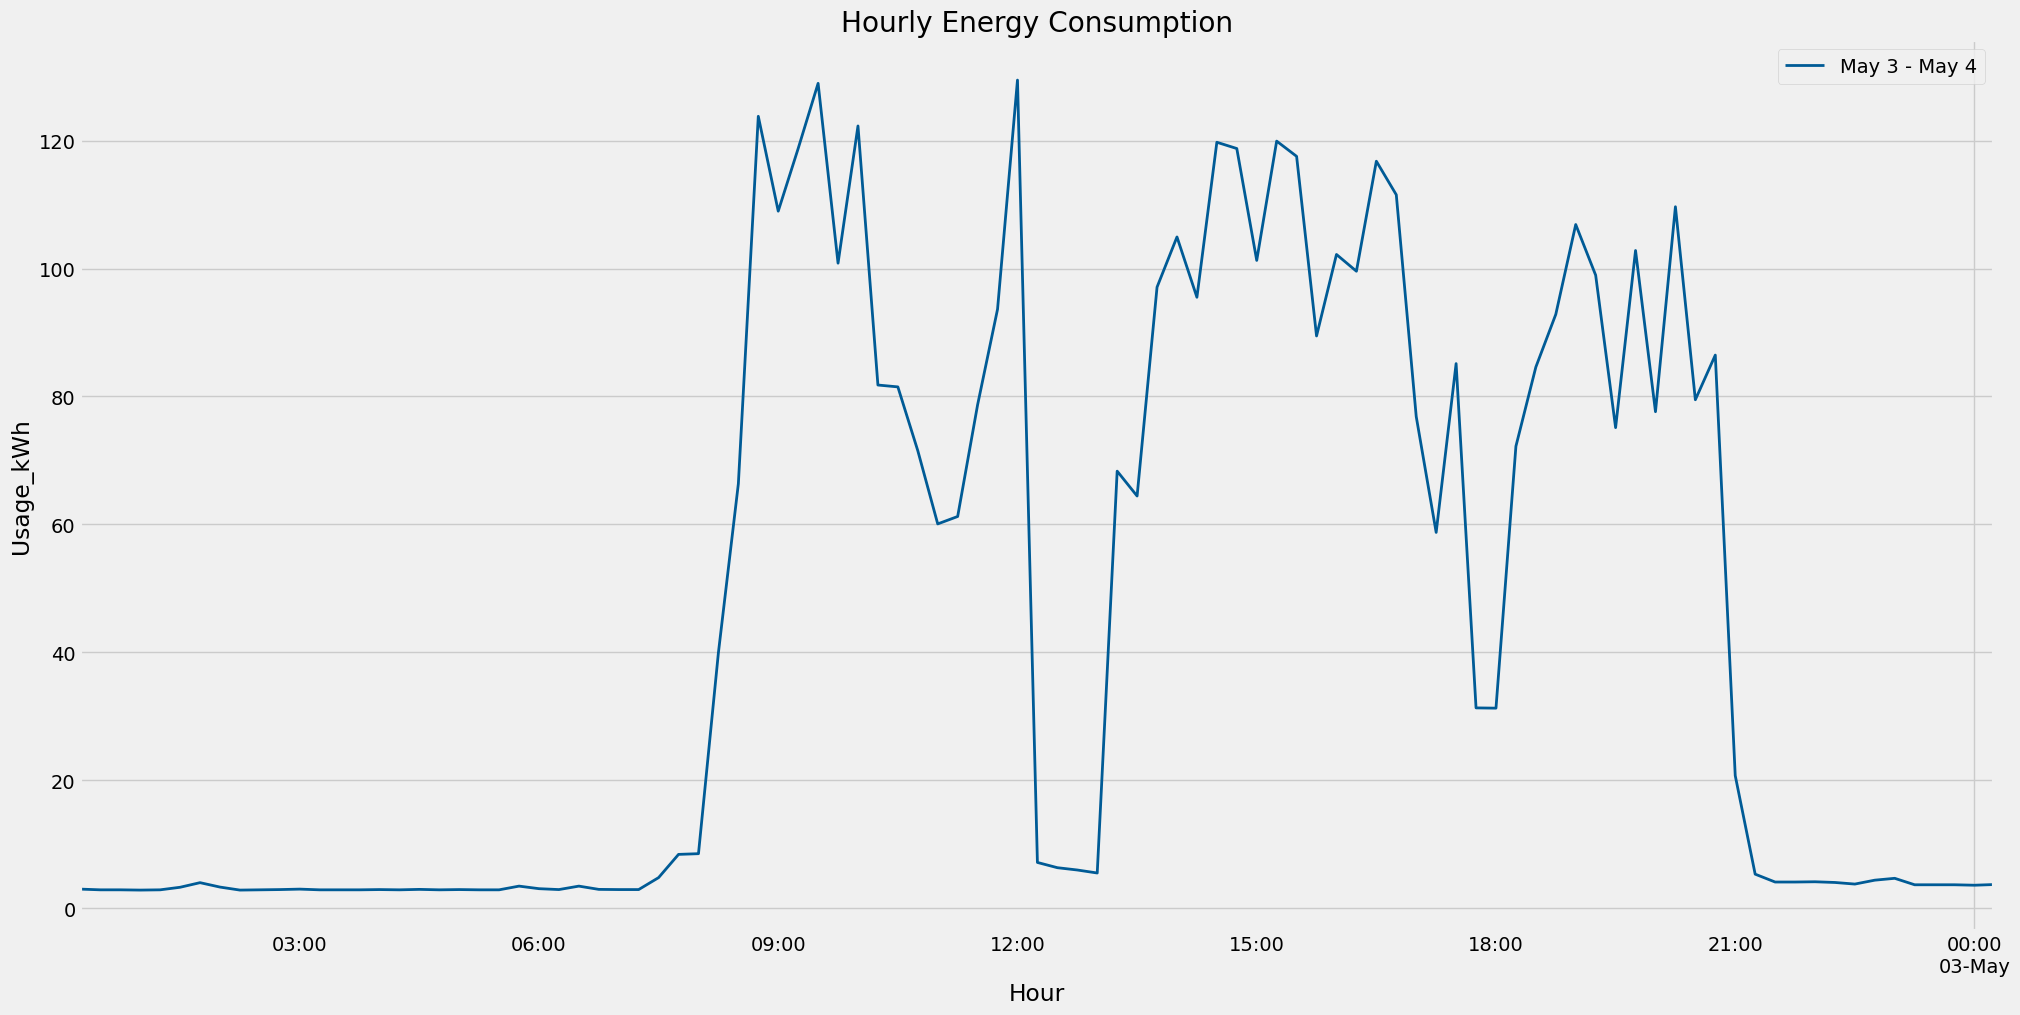

In [26]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(22, 11))

# Plot first subset
ea.loc[(ea.index >= '2018-05-02 00:15:00') & (ea.index <= '2018-05-03 00:15:00')].plot(ax=ax, style='-', linewidth=2, label='Jan 3 - Jan 4', color= "#005b96")

# Plot second subset on the same axis
#ea.loc[(ea.index >= '2018-05-03 00:15:00') & (ea.index <= '2018-05-04 00:15:00')].plot(ax=ax, style='-', color='red', linewidth=0.8, label='Jan 4 - Jan 5')

#
#ea.loc[(ea.index >= '2018-05-04 00:15:00') & (ea.index <= '2018-05-05 00:15:00')].plot(ax=ax, style='-', color='gray', linewidth=0.8, label='Jan 5 - Jan 6')
# Show the plot
plt.title('Hourly Energy Consumption')
plt.ylabel('Usage_kWh')
plt.xlabel('Hour')
plt.legend(['May 3 - May 4', 'May 4 - May 5', 'May 5 - May 6'])
plt.savefig('hourly-usage.png')
plt.show()


# Power Quality & Efficiency Analysis

In [6]:
df = pd.read_csv('Steel_industry_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')
# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
df.index = df.index.map(adjust_date)
df['Power_Factor'] = df[['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']].mean(axis=1) / 100

In [7]:
high_pf = df[df['Power_Factor'] > 0.90]
percentage_high_pf = (len(high_pf) / len(df)) * 100
print(f'The above 90% power efficiency of this manufacturing plant during measuring period is: {percentage_high_pf:.2f}%')

The above 90% power efficiency of this manufacturing plant during measuring period is: 39.16%


In [8]:
# Calculate total energy consumption
total_energy = df['Usage_kWh'].sum()

# Calculate energy consumed when Power Factor > 0.9
efficient_energy = df[df['Power_Factor'] > 0.9]['Usage_kWh'].sum()

# Calculate weighted efficiency percentage
efficiency_percentage = (efficient_energy / total_energy) * 100

print(f"Weighted Energy Efficiency: {efficiency_percentage:.2f}%")

Weighted Energy Efficiency: 87.14%


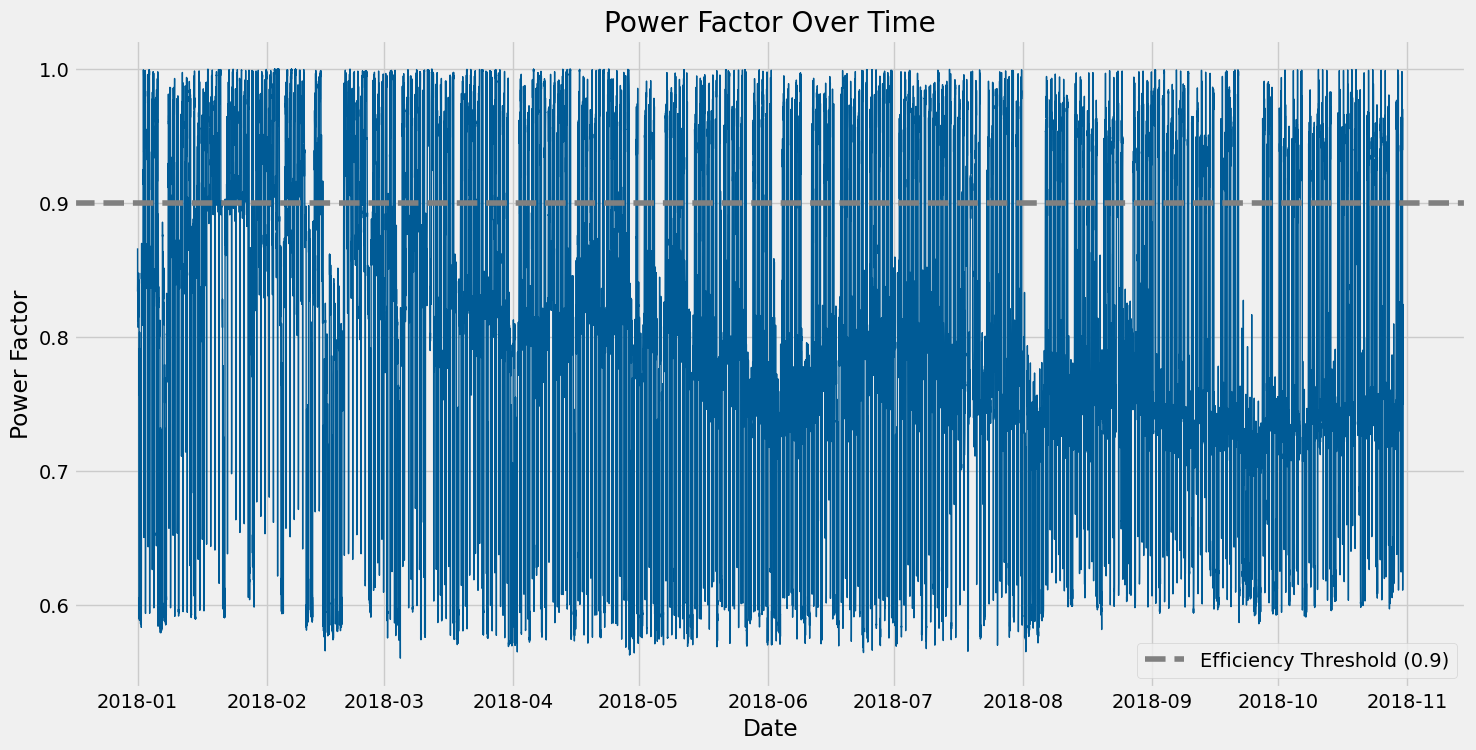

In [14]:
# Power Factor plotting in whole dataset 
plt.figure(figsize=(16, 8))
resolution_begin1 = '2018-01-01'
resolution_end1 = '2018-10-30'
plt.plot(df.loc[resolution_begin1:resolution_end1].index, df.loc[resolution_begin1:resolution_end1]['Power_Factor'], linestyle='-', color="#005b96",linewidth=1)

plt.xlabel('Date')
plt.ylabel('Power Factor')
plt.title('Power Factor Over Time')
plt.axhline(y=0.9, color='gray', linestyle='--', label='Efficiency Threshold (0.9)')
plt.legend()
plt.grid(True)
plt.savefig('pf_total.png')
plt.show()


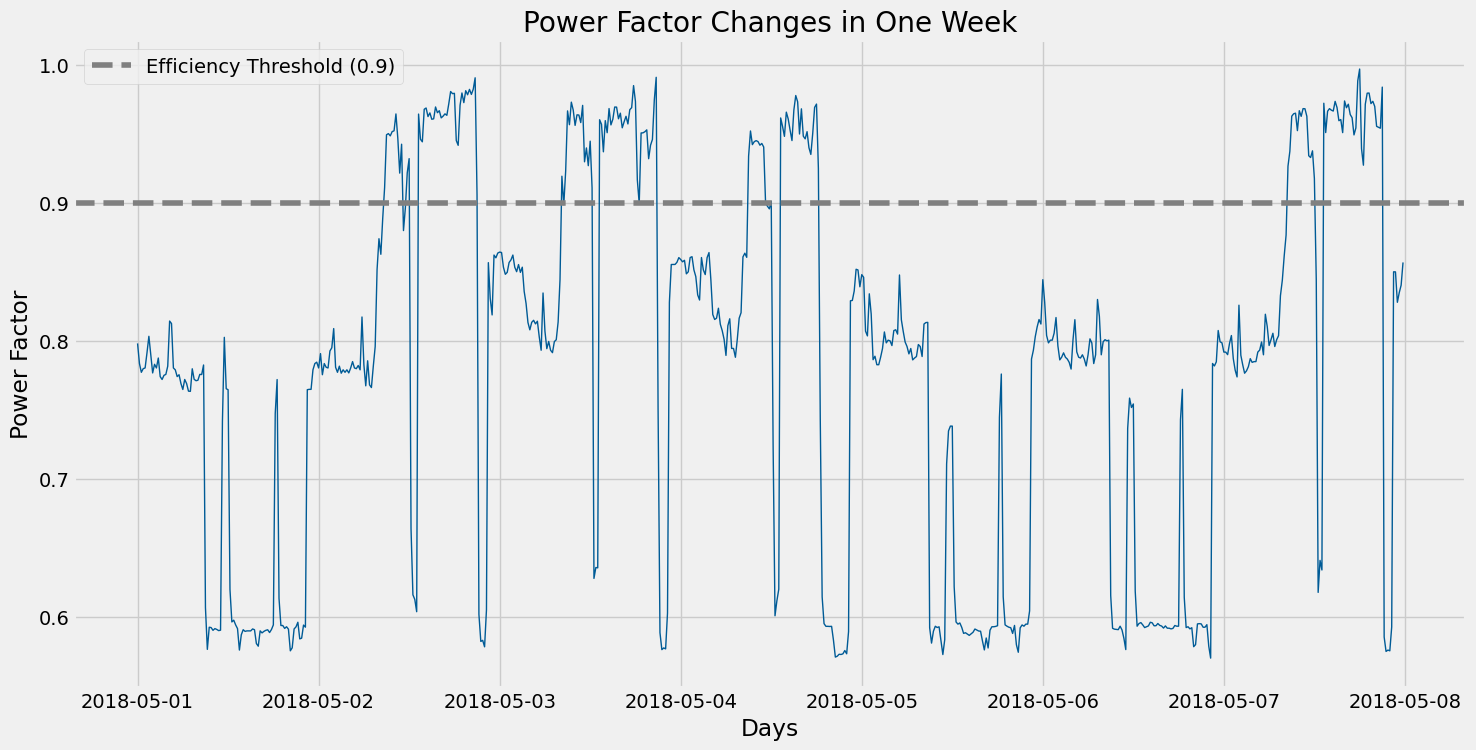

In [17]:

# Power factor in one Week plotting
plt.figure(figsize=(16, 8))
resolution_begin2 = '2018-05-01'
resolution_end2 = '2018-05-07'
plt.plot(df.loc[resolution_begin2:resolution_end2].index, df.loc[resolution_begin2:resolution_end2]['Power_Factor'], linestyle='-', color="#005b96",linewidth=1)

plt.xlabel('Days')
plt.ylabel('Power Factor')
plt.title('Power Factor Changes in One Week')
plt.axhline(y=0.9, color='gray', linestyle='--', label='Efficiency Threshold (0.9)')
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.savefig('pf-week.png')
plt.show()


# Carbon Footprint & Sustainability

In [19]:
df = pd.read_csv('Steel_industry_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
df.index = df.index.map(adjust_date)
df.head(100)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...
2018-01-02 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
2018-01-02 00:15:00,3.20,3.10,0.0,0.0,71.82,100.0,900,Weekday,Tuesday,Light_Load
2018-01-02 00:30:00,3.85,4.61,0.0,0.0,64.10,100.0,1800,Weekday,Tuesday,Light_Load


In [20]:
light_load_co2 = df[df['Load_Type'] == 'Light_Load']['CO2(tCO2)'].sum()
med_load_co2 = df[df['Load_Type'] == 'Medium_Load']['CO2(tCO2)'].sum()
max_load_co2 = df[df['Load_Type'] == 'Maximum_Load']['CO2(tCO2)'].sum()

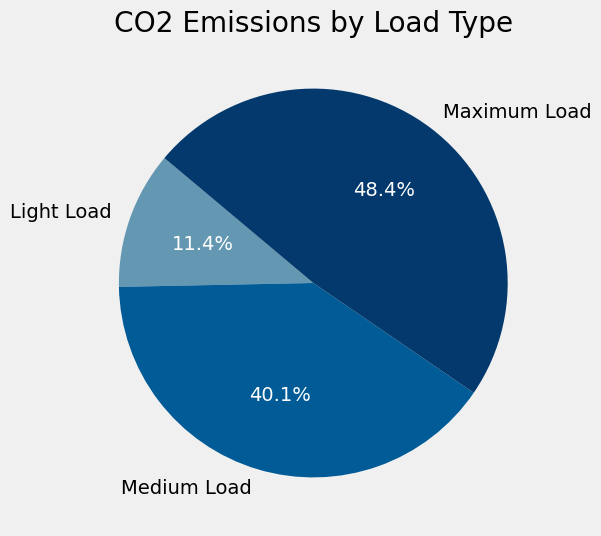

In [28]:
import matplotlib.pyplot as plt

# Data
labels = ['Light Load', 'Medium Load', 'Maximum Load']
co2_values = [light_load_co2, med_load_co2, max_load_co2]

# Plot
plt.figure(figsize=(6, 6))  # Set figure size
# Create the pie chart
wedges, texts, autotexts = plt.pie(co2_values, labels=labels, autopct='%1.1f%%', startangle=140, 
                                   colors=["#6497b1", "#005b96", "#03396c"])

# Set the percentage text (autotexts) to white
plt.setp(autotexts, color='white')

# Set the labels (texts) to black
plt.setp(texts, color='black')
# Title
plt.title('CO2 Emissions by Load Type')
plt.savefig('carbon_pichart.png')
# Show plot
plt.show()


# Features Analysis

In [29]:
df = pd.read_csv('Steel_industry_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
df.index = df.index.map(adjust_date)

In [30]:
def split_date(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df
    

In [31]:
df = split_date(df)

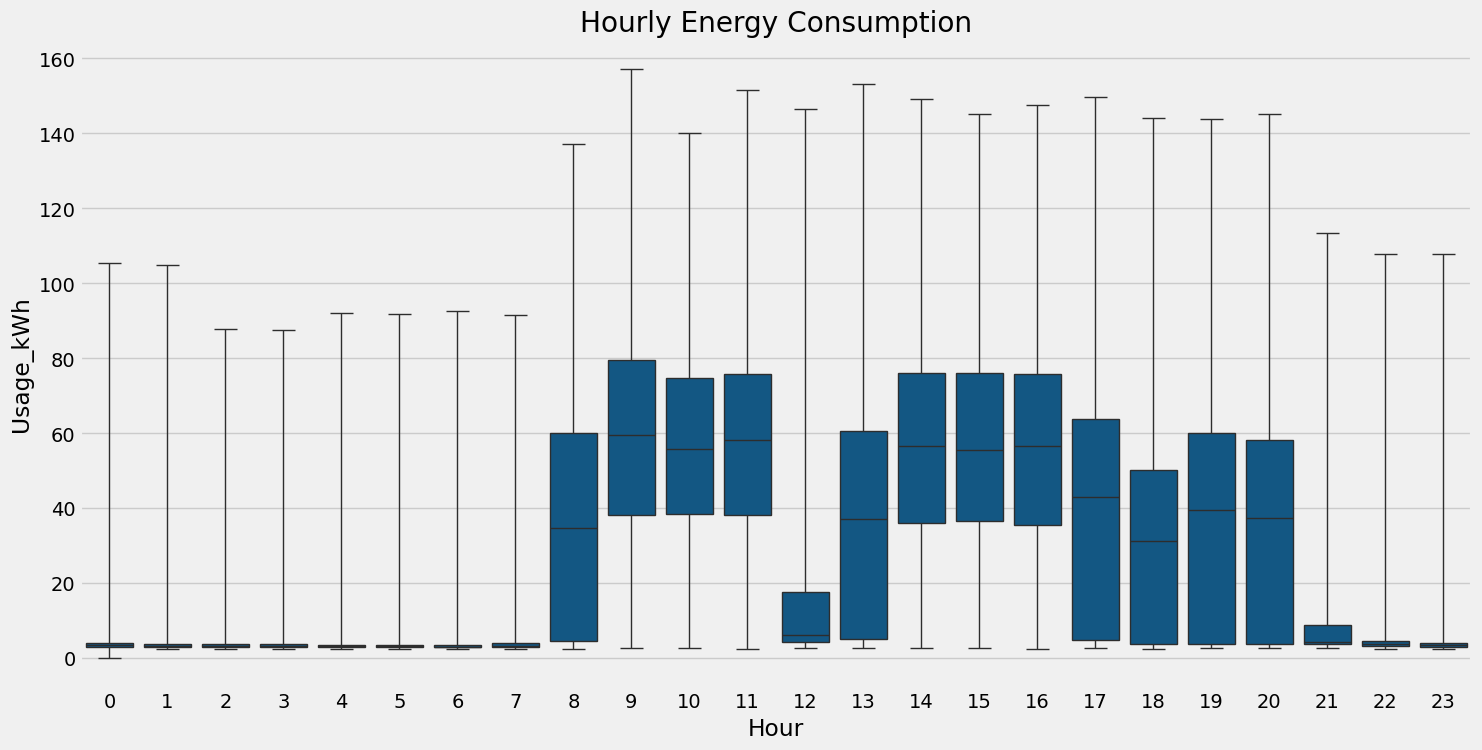

In [33]:
fig, ax = plt.subplots(figsize = (16,8))
sns.boxplot(data = df, x = 'hour', y = 'Usage_kWh',whis=(0, 100), color= "#005b96")
ax.set_title('Hourly Energy Consumption')
plt.xlabel('Hour')
fig.savefig('boxplot_hourly_usage.png')

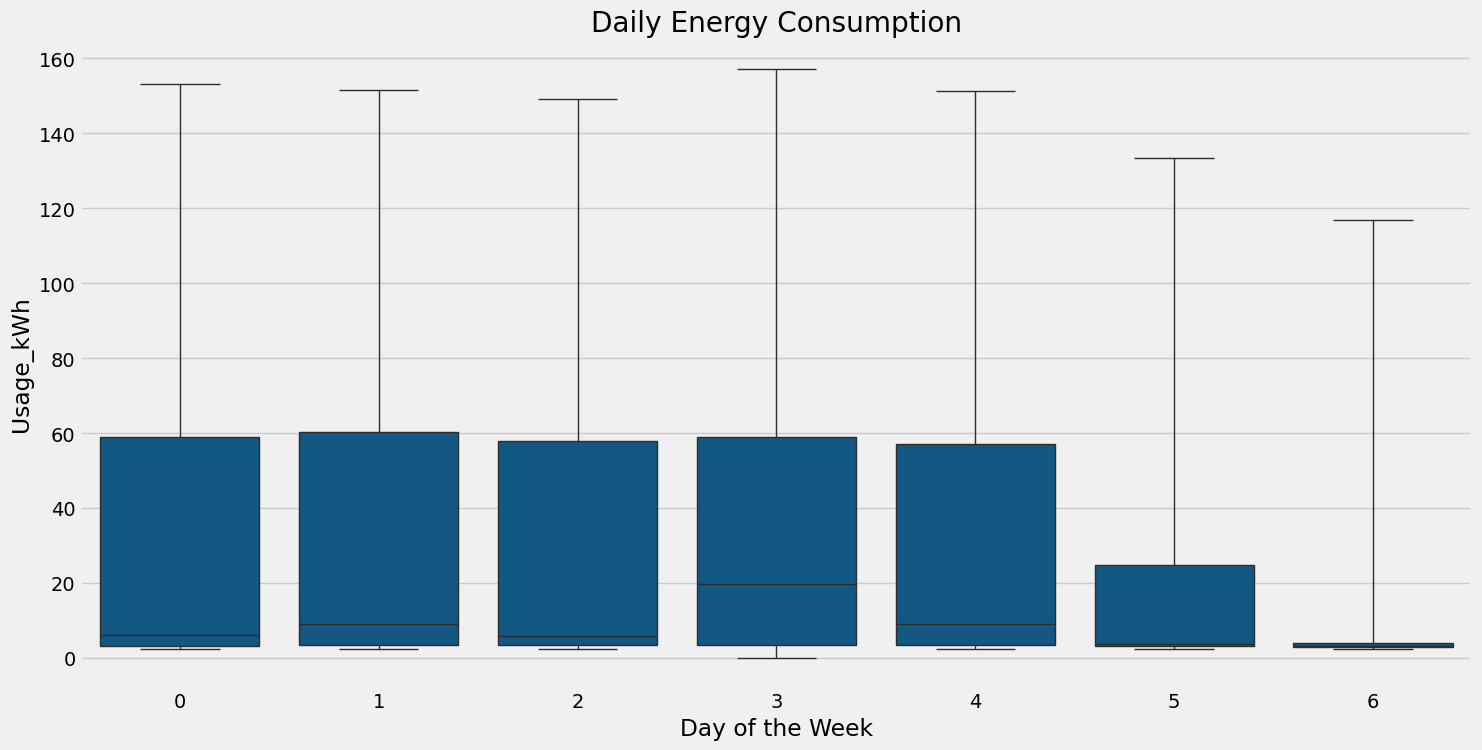

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data = df, x = 'dayofweek', y = 'Usage_kWh',whis=(0, 100), color = "#005b96")
plt.xlabel('Day of the Week')
ax.set_title('Daily Energy Consumption')
fig.savefig('boxplot_daily_usage.png')

Text(0.5, 1.0, 'monthly Power Consumption')

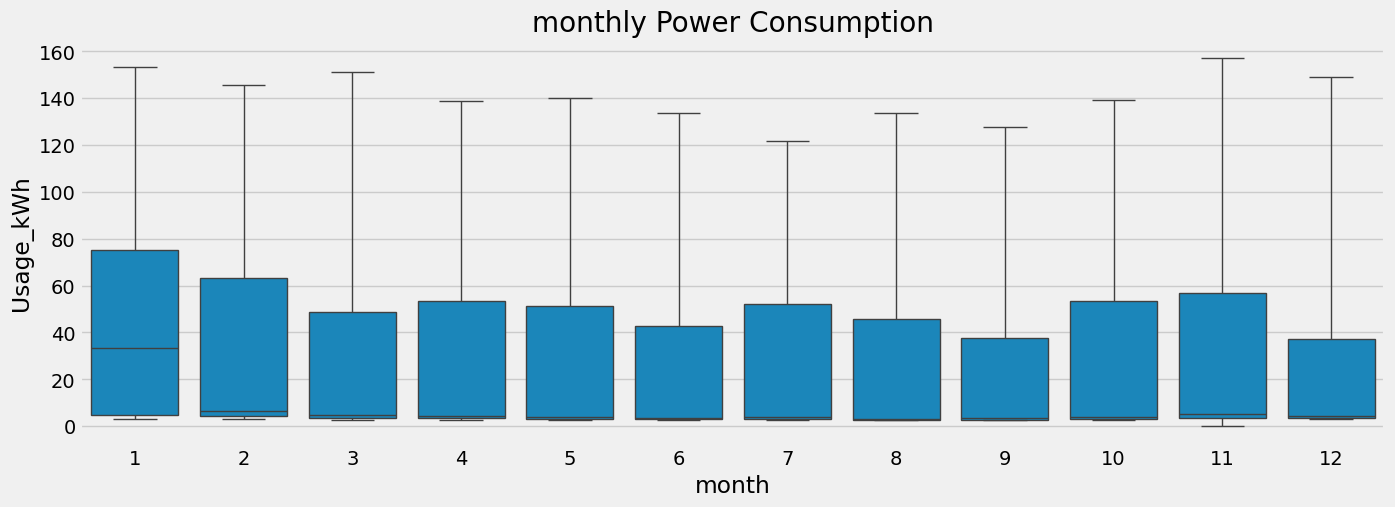

In [18]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y = 'Usage_kWh',whis=(0, 100))
ax.set_title('monthly Power Consumption')

Text(0.5, 1.0, 'monthly carbon footprint')

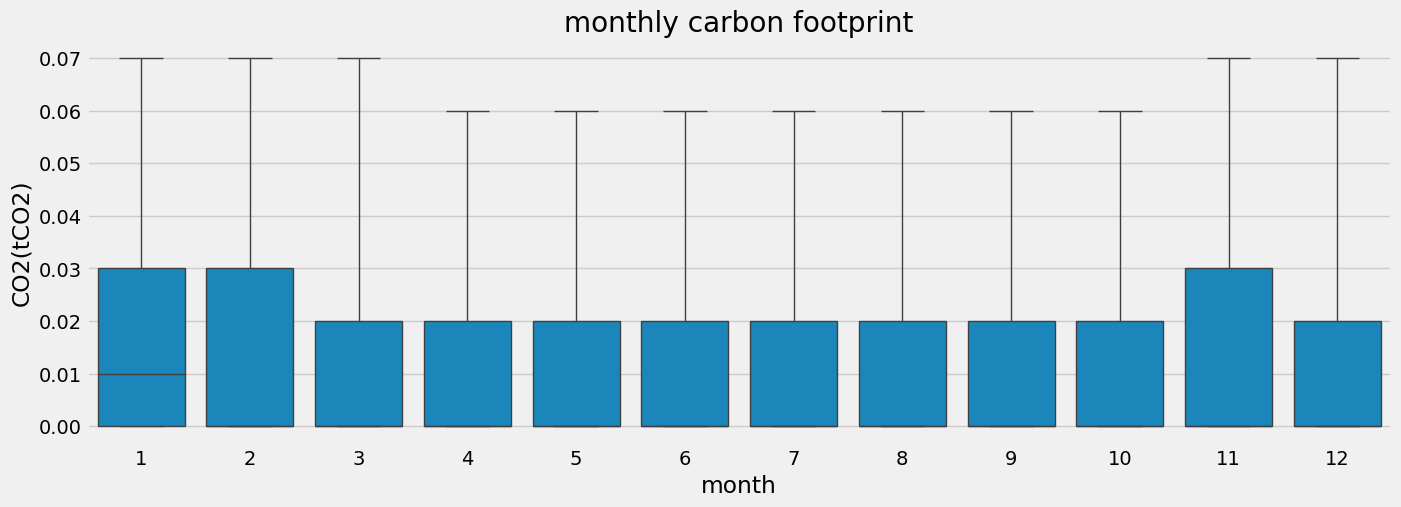

In [24]:
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y = 'CO2(tCO2)',whis=(0, 100))
ax.set_title('monthly carbon footprint')

Text(0.5, 1.0, 'monthly power factor')

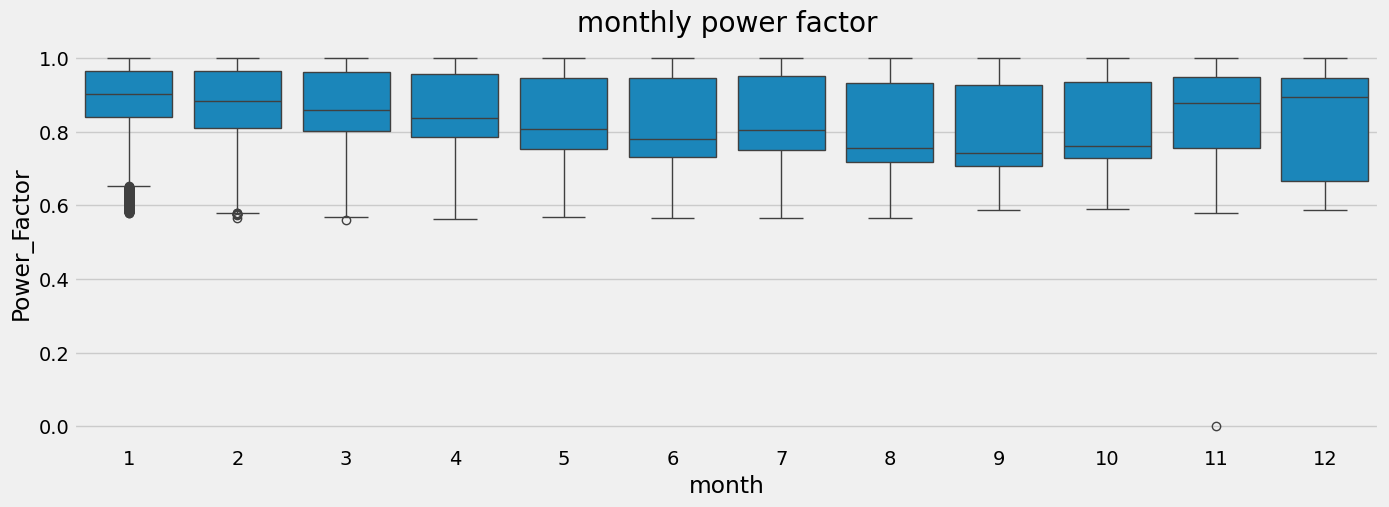

In [26]:
df['Power_Factor'] = df[['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']].mean(axis=1) / 100

fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y = 'Power_Factor')
ax.set_title('monthly power factor')

# Model Creating

In [2]:
df = pd.read_csv('Steel_industry_data.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

# There was a problem with dates on main csv file e.g after 2018-01-01 23:45:00 we have 2018-01-01 00:00:00 while we should have 2018-01-02 00:00:00 
# Function to fix the problem
def adjust_date(date):
    # Check if the time is 00:00:00
    if date.time() == pd.Timestamp('00:00:00').time():
        return date + timedelta(days=1)  # Move forward by one day
    else:
        return date  # return the same dates that do not have 00:00:00 as time

# Apply the function to the index
df.index = df.index.map(adjust_date)
# Drop 'Day_of_week' column
df = df.drop(columns=['Day_of_week'])

# Convert categorical columns to numeric
encoder = LabelEncoder()
df['WeekStatus'] = encoder.fit_transform(df['WeekStatus'])
df['Load_Type'] = encoder.fit_transform(df['Load_Type'])

In [3]:
train_data = df.loc[df.index<'2018-11-01']
test_data = df.loc[df.index >= '2018-11-01']

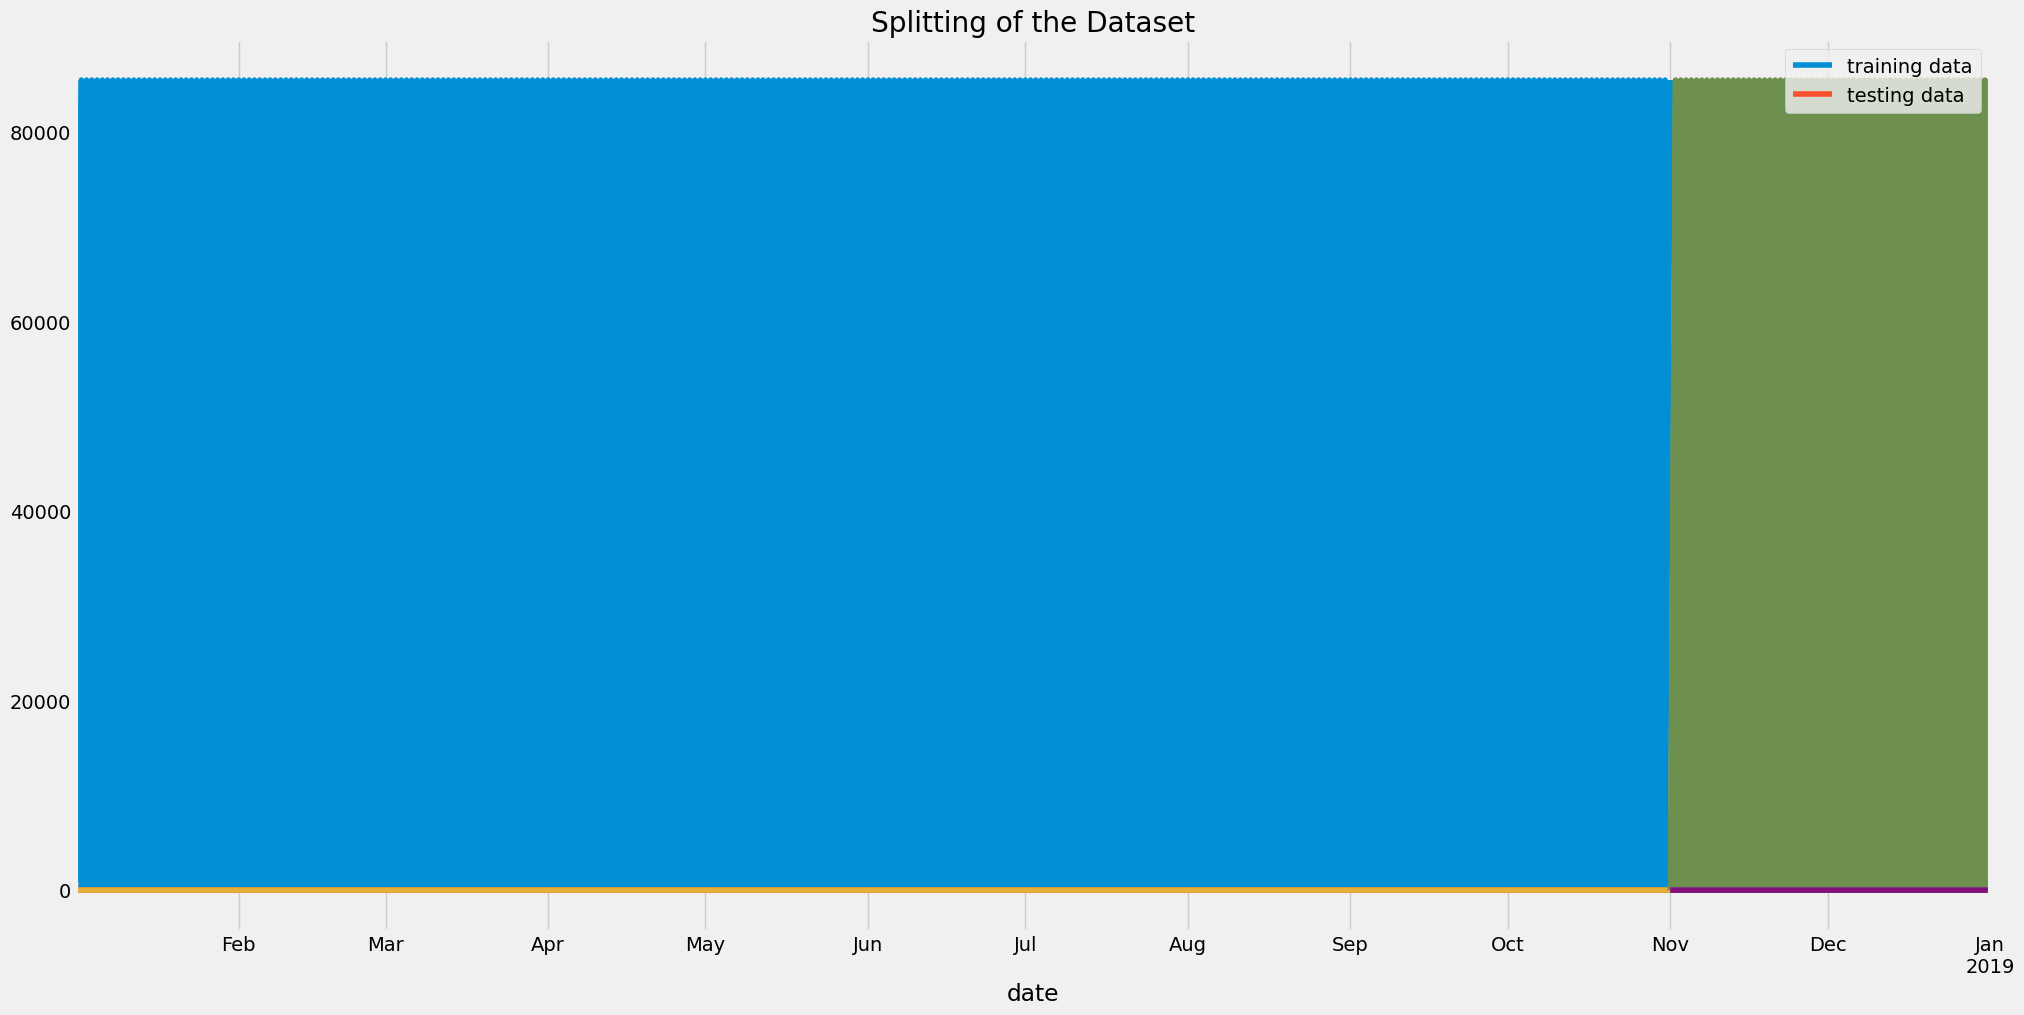

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22, 11))

# Plot training data without individual series legends
train_data.plot(ax=ax, legend=False)

# Plot testing data without individual series legends
test_data.plot(ax=ax, legend=False)

# Manually add a legend for training and testing data
plt.title('Splitting of the Dataset')
ax.legend(['training data', 'testing data'])
plt.savefig('splitting.png')
plt.show()

In [6]:
def split_date(df):
    df = df.copy() # create a copy to prevent slice from data base error
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df
train = split_date(train_data)
test = split_date(test_data)
train.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Load_Type', 'hour', 'dayofweek', 'month'],
      dtype='object')

In [7]:
FEATURES = ['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Load_Type', 'hour', 'dayofweek', 'month']
TARGET = ['Usage_kWh']

In [39]:
X_train =  train[FEATURES]
Y_train = train[TARGET]

X_test =  test[FEATURES]
Y_test = test[TARGET]

In [50]:
reg = xgb.XGBRegressor(
    #tree_method="hist",    # It just works better without our Nvidia artwork :)
    #device="cuda",   # for new version of XGBoost we need to have that. ths syntax has changed.
    #nthread=-1,  # Use all CPU cores
    n_estimators=50000, 
    learning_rate=0.02,  
    max_depth=5,  
    min_child_weight=3,  
    subsample=0.85,  
    colsample_bytree=0.85,  
    reg_lambda=2,  
    reg_alpha=1,  
    early_stopping_rounds=2500,  
    random_state=42
)
reg.fit(X_train, Y_train, 
        eval_set=[(X_train, Y_train), (X_test, Y_test)], 
        verbose=5000)


[0]	validation_0-rmse:33.20239	validation_1-rmse:30.66306
[5000]	validation_0-rmse:0.43007	validation_1-rmse:0.77375
[10000]	validation_0-rmse:0.28696	validation_1-rmse:0.68353
[15000]	validation_0-rmse:0.22827	validation_1-rmse:0.66098
[20000]	validation_0-rmse:0.19514	validation_1-rmse:0.65293
[25000]	validation_0-rmse:0.17357	validation_1-rmse:0.64845
[30000]	validation_0-rmse:0.15836	validation_1-rmse:0.64760
[35000]	validation_0-rmse:0.14679	validation_1-rmse:0.64665
[37478]	validation_0-rmse:0.14204	validation_1-rmse:0.64671


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=2500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=None, num_parallel_tree=None, ...)

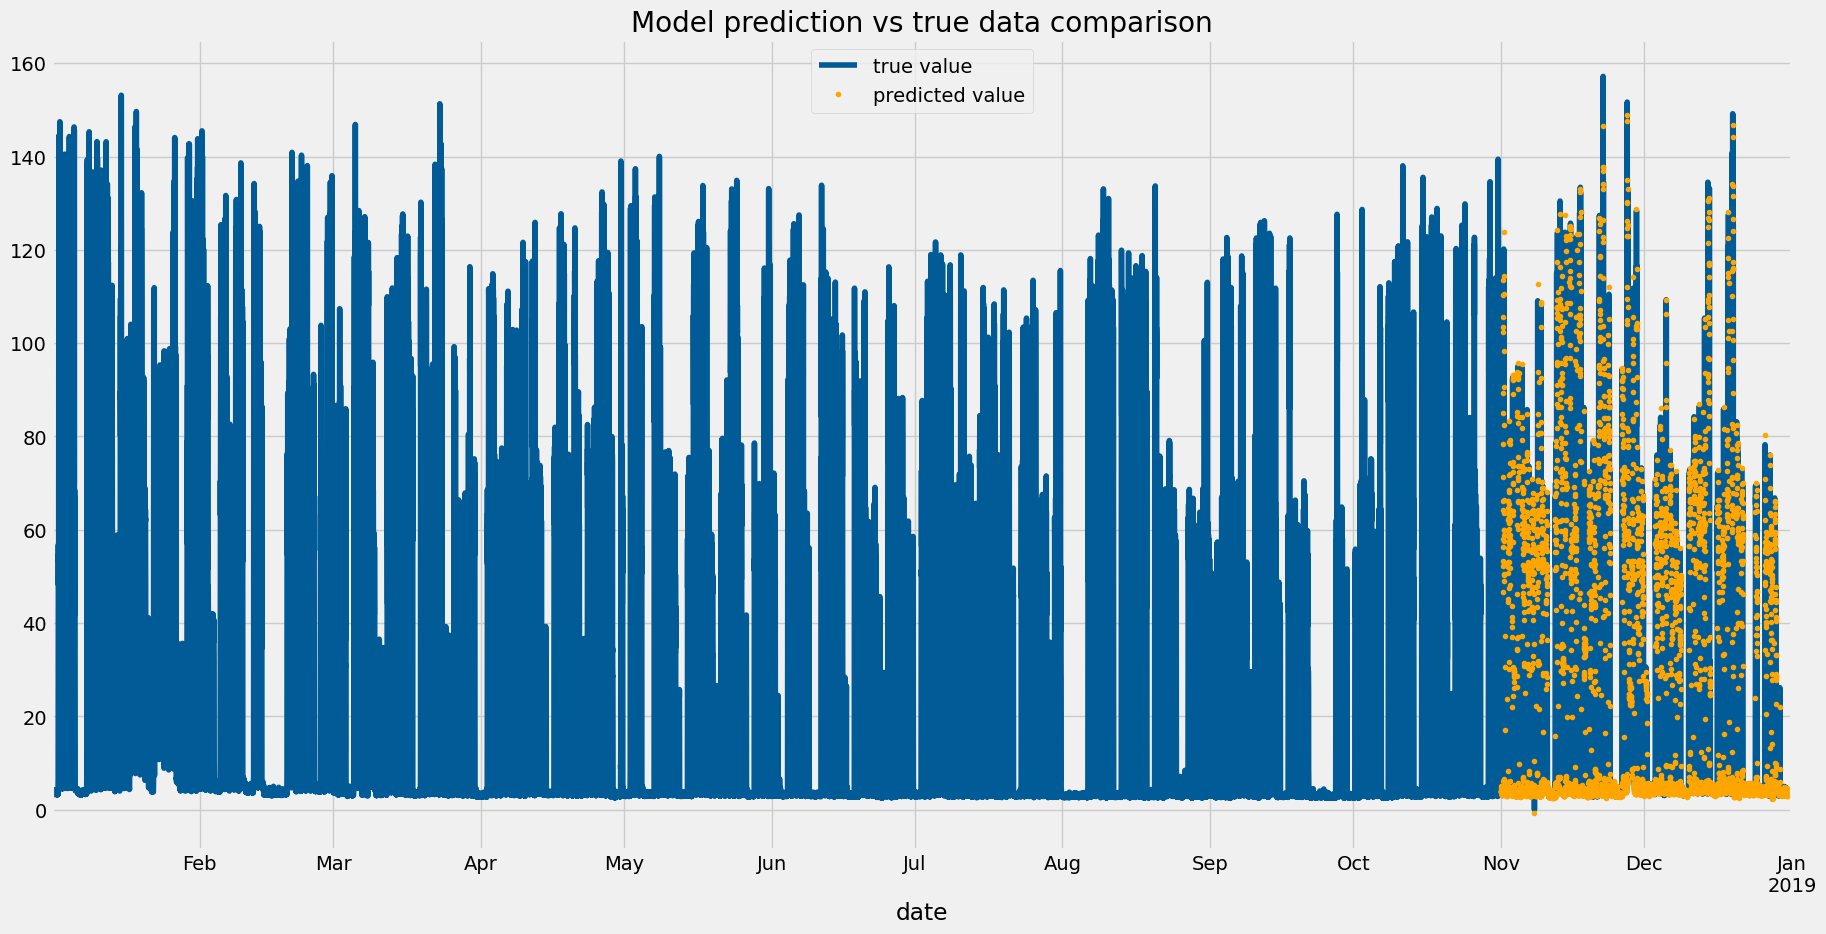

In [81]:
test['Predictions'] = reg.predict(X_test)

# Instead of merging, assign directly
df['Predictions'] = test['Predictions']

ax = df[['Usage_kWh']].plot(figsize=(20,10),color = "#005b96")
df['Predictions'].plot(ax=ax, style='.', color = 'orange')

plt.legend(['true value', 'predicted value'])
ax.set_title('Model prediction vs true data comparison')  # Fixed settitle -> set_title
plt.savefig('total_prediction.png')
plt.show()


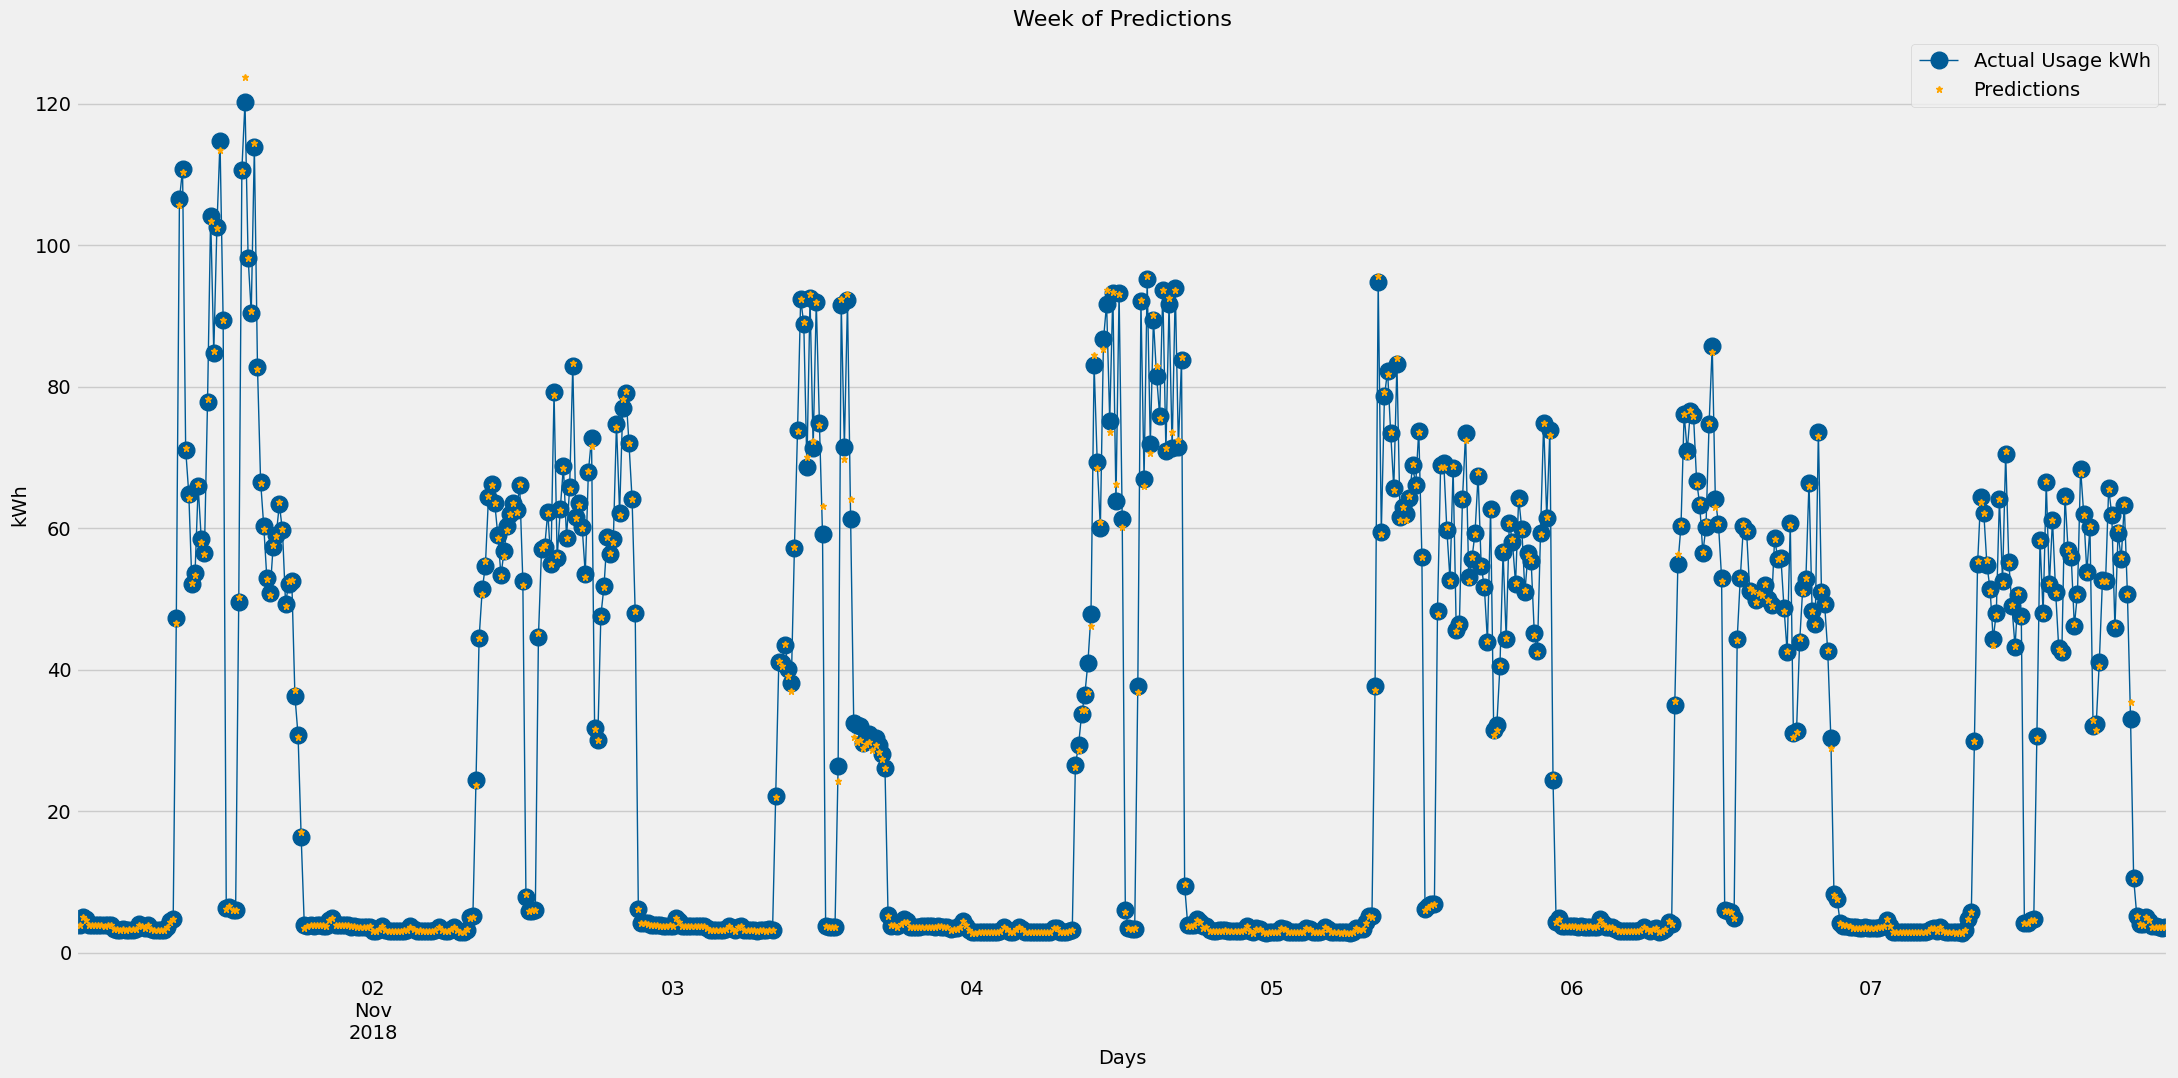

In [82]:

ax = df.loc[(df.index > '2018-11-01') & (df.index < '2018-11-08')]['Usage_kWh'].plot(
    figsize=(22,11), style='o-', color = "#005b96", linewidth=1, label='Actual Usage kWh', markersize=12)

df.loc[(df.index > '2018-11-01') & (df.index < '2018-11-08')]['Predictions'].plot(
    style='*', color = 'orange', linewidth=1, label='Predictions', markersize=5)

plt.title('Week of Predictions', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('kWh', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('week_prediction.png')
plt.show()


## Final Model Metrics

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicting the target variable on the test data
Y_pred = reg.predict(X_test)

# Calculate MAE, MSE, RMSE, and R²
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

# Display the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.3202
Mean Squared Error (MSE): 0.4181
Root Mean Squared Error (RMSE): 0.6466
R-squared (R²): 0.9996
